In [prior research we have provided a method of estimating the liquidity in payment channels](https://arxiv.org/abs/2103.08576). This was used to compute success probabilities for payments. The proposed model has several inacuracies:

1. It assumes the liquidity distributions in channels are independent of each other
2. it uses a uniform distribution to model the uncertainty

The second issue is being addressed through the [introduction of bimodal models](https://lightning.engineering/posts/2024-05-23-pathfinding-2/). However [we believe the observed bimodal distributions emerge due to the geometry of payment channel network](https://github.com/renepickhardt/Lightning-Network-Limitations/blob/main/Limits%20of%20two%20party%20channels/Geometric%20Argument%20for%20Bimodal%20Liquidity%20Distribution%20in%20Payment%20Channels%20of%20the%20Lightning%20Network.ipynb). This happens in particular if the first assumption is dropped. 

## Contribution
This notebook provides a tiny examples to demonstrate how one can compute the payment success rate between two peers on the lightning network for a payment amount even if no information about the liquidity distribution is availble. We do however assume that the sender owns more coins that he wishes to send (Though we could easily drop that assumption).

For this we start from the assumption that all feasible wealth distributions in the given topology are equally likely to occur. As payments are changes in the wealth distribution **we just have to test for all feasible wealth distributions if the change induced by the payment is still a feasible wealth distribution**. The fraction of payments for which this is possible is the expected success probability of a payment. 

**Caution** this assumes that all feasible wealth distributions are equally likely. This is not the same as assuming that the wealth is qually distributed. The reason is that the network topology makes many wealth distributions infesible. Thus despite assuming uniformity among the feasible wealth distributions this assumption is hopefully close enough to match the reality of a skew power law distributed wealth.

**Important**: The sucess probabilities here are not related to attempt probabilities! Instead the probabilties computed with this method estimate weather it is likely that with sufficient attempts a payment is feasible. 

## Generalization for larger Networks
Enumerating and testing all feasible wealth distributions - as done in this example - is impractical in larger networks. However the method can be generalized by two means:

1. We can statistically sample feasible wealth distributions (This is different and more complex than sampling channel states but [it can be done with this library](https://github.com/dgdguk/drs/tree/master))
2. For the sampled distributions we can test if the change in the wealth vector induced by a payment is still feasible. This is done by [solving a system of linear equations given by the network topology over the bounded polytope of feasible states](https://github.com/renepickhardt/Lightning-Network-Limitations/pull/2). In particular this is possible in polynomial time.

The generalization is not part of this notebook as we wish to focus on the principle here. A full [academic paper that formally elaborates on this is being produced in this repository](https://github.com/renepickhardt/Lightning-Network-Limitations/tree/main/Limits%20of%20two%20party%20channels/paper).

## Acknowledgements: 

Kudos to Rene Treffer who made and shared a similar observation with me towards the end of 2023 when he suggested to drop the assumption that the liquidity in channels is distributed independently of each other. The work is sponsored through a [grant from OpenSats](https://opensats.org/blog/rene-pickhardt-receives-lts-grant) and through [individual patreons](https://www.patreon.com/renepickhardt).

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#CAUTION the reminder of the code works only with a network of 3 channels which must be indexed exactly in this way
channels={(0,1):3,(0,2):7,(1,2):11}
C = sum(channels.values())

In [2]:
#we generate all feasible wealth distributions on LN by going through all LN states and add the corresponding wealth distributions to a set
ln = set()
for x in range(channels[(0,1)]+1):
    for y in range(channels[(0,2)]+1):
        for z in range(channels[(1,2)]+1):
            a = x+y
            b = channels[(0,1)]-x + z
            c = channels[(0,2)]-y + channels[1,2] - z
            ln.add((a,b,c))


This is the core method to compute the ikelihood that a payment of a certain amount `amtount` between the two peers `src` and `dest` is feasible. From a list of all feasible wealth distributions we test how often the payment would be feasible. 

Conducting Payments is the same as changing the wealth vector: 

Let $w=(w_1,\dots,w_n)$ be a wealth vector. Furth let $b_1,\dots,b_n \in \mathbb{Z}^n$ be unit base vectors that span the space of feasible wealth distributions. Then a payment is the new wealth vector $w'$ which can be computed via the following:

$w'= w -amt\cdot b_{src} + amt\cdot b_{dest}$

if $w'$ is feasible then the payment was possible.

**By default this takes only start states in which the `src` node has more liquidity than `amount`.**


In [3]:
def probability_to_be_feasible(src,dest,amount,feasible,debug=True,sender_has_enough_liquidity=True):
    possible=0
    impossible=0
    rounds = 0
    for dist in feasible:
        if sender_has_enough_liquidity == True and dist[src]<amount:
            continue
        rounds += 1
        new = list(dist)
        new[src]-=amount
        new[dest]+=amount
        test = tuple(new)
        #print(dist, test)
        if test in feasible:
            possible+=1
        else:
            impossible+=1

    if rounds>0:
        if debug:
            print("{:2} coins from ({}) to ({})\t\t expected success rate = {:4.2f}% \t\t possible: {} impossible: {}".format(
                amount, src, dest, (possible*100./rounds),possible,impossible,rounds))
        return possible/rounds
    else:
        return None


## Optional Comparison with prior research

The follwoing can be ignored it is just an adhoc implementation of probabilistic path fining and the min cost flow approach. I thought it might be usefull to compare the probabilities weather a payment is feasible with the attempt probabilities of payment paths and [optimally reliable payment flows](https://arxiv.org/abs/2107.05322) as these strategies are being used on the network in some form.

In [4]:
def probabilistic_pathfinding(x,y,amount,channels):
    cap = channels[(x,y)]
    f1 = 0
    if amount <= cap:
        f1 = 1-amount/(cap+1)
    
    ids = [0,1,2]
    ids.remove(x)
    ids.remove(y)
    other = ids[0]
    idx1 = tuple(sorted((x,other)))
    cap1 = channels[idx1]
    idx2 = tuple(sorted((y,other)))
    cap2 = channels[idx2]
    f2 = 0
    if amount<=min(cap1,cap2):
        f2 = (1-amount/(cap1+1)) * (1-amount/(cap2+1))

    optimal_flow = 0
    p1 = 0
    p2 = 0
    for s in range(amount):
        t = amount - s
        if s>cap or t>cap1 or t>cap2:
            continue
        p = (1-s/(cap+1))*(1-t/(cap1+1)) * (1-t/(cap2+1))
        if p>optimal_flow:
            p1=s
            p2=t
            optimal_flow=p
    
    print("P1: s={:4.2f}% ({})---{:2}---->({})".format(f1*100,x,cap,y))
    print("P2: s={:4.2f}% ({})---{:2}---->({})---{:2}---->({})".format(f2*100,x,cap1,other,cap2,y))
    print("Not both P1 and P2 fail: {:4.2f}%".format((1-(1-f1)*(1-f2))*100))
    print("MCF: s={:4.2f}% {} to P1 and {} to P2".format(100*optimal_flow,p1,p2))
    return optimal_flow, (f1, f2)
    

## Results and experiments

In [5]:
success_rates = {i:[] for i in range(1,C+1)}
success_rates_mcf = {i:[] for i in range(1,C+1)}

for x,y in [(0,1),(0,2),(1,2)]:
    for amount in range(1,C+1):
        #in order to make a fair comparision to probabilistic path finding an MCF approaches we have to 
        #assume we don't know anything about the liquidity of the sender
        r = probability_to_be_feasible(x,y,amount,ln,sender_has_enough_liquidity=False)
        success_rates[amount].append(r)
        if r is not None:
            mcf,paths = probabilistic_pathfinding(x,y,amount,channels)
            success_rates_mcf[amount].append(mcf)
            print()



 1 coins from (0) to (1)		 expected success rate = 87.58% 		 possible: 134 impossible: 19
P1: s=75.00% (0)--- 3---->(1)
P2: s=80.21% (0)--- 7---->(2)---11---->(1)
Not both P1 and P2 fail: 95.05%
MCF: s=80.21% 0 to P1 and 1 to P2

 2 coins from (0) to (1)		 expected success rate = 75.16% 		 possible: 115 impossible: 38
P1: s=50.00% (0)--- 3---->(1)
P2: s=62.50% (0)--- 7---->(2)---11---->(1)
Not both P1 and P2 fail: 81.25%
MCF: s=62.50% 0 to P1 and 2 to P2

 3 coins from (0) to (1)		 expected success rate = 62.75% 		 possible: 96 impossible: 57
P1: s=25.00% (0)--- 3---->(1)
P2: s=46.88% (0)--- 7---->(2)---11---->(1)
Not both P1 and P2 fail: 60.16%
MCF: s=46.88% 0 to P1 and 3 to P2

 4 coins from (0) to (1)		 expected success rate = 50.33% 		 possible: 77 impossible: 76
P1: s=0.00% (0)--- 3---->(1)
P2: s=33.33% (0)--- 7---->(2)---11---->(1)
Not both P1 and P2 fail: 33.33%
MCF: s=35.16% 1 to P1 and 3 to P2

 5 coins from (0) to (1)		 expected success rate = 39.22% 		 possible: 60 impossibl

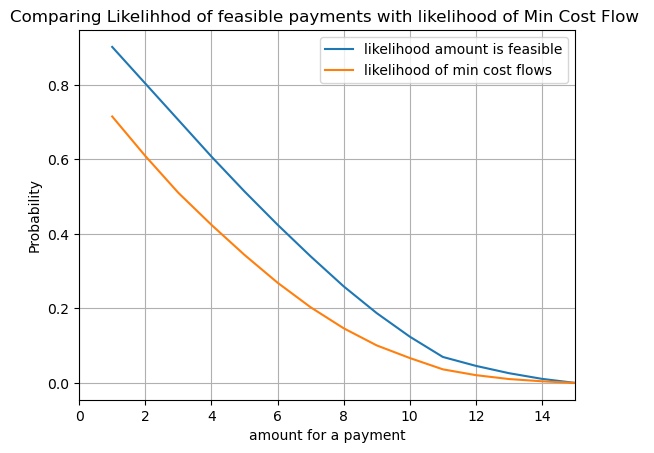

In [6]:
x_vals = list(range(1,C+1))
plt.title("Comparing Likelihhod of feasible payments with likelihood of Min Cost Flow ")
plt.plot(x_vals,[np.mean(success_rates[i]) for i in x_vals],label="likelihood amount is feasible")
plt.plot(x_vals,[np.mean(success_rates_mcf[i]) for i in x_vals],label="likelihood of min cost flows")

plt.xlim(0,15)
plt.xlabel("amount for a payment")
plt.ylabel("Probability")
plt.grid()
plt.legend()
plt.show()

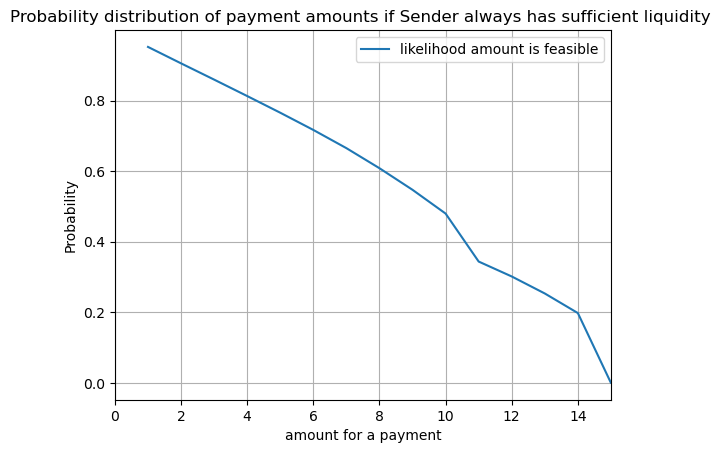

In [7]:
success_rates = {i:[] for i in range(1,C+1)}
for x,y in [(0,1),(1,0),(0,2),(2,0),(1,2),(2,1)]:
    for amount in range(1,C+1):
        l = probability_to_be_feasible(x,y,amount,ln,False)
        if l is not None:
            success_rates[amount].append(l)
            #print(x,y,amount,l,probability_to_be_feasible(x,y,amount,onchain,False))
    #print()

plt.title("Probability distribution of payment amounts if Sender always has sufficient liquidity ")
y_vals = [np.mean(success_rates[i]) for i in x_vals if len(success_rates[i])>0]
y_vals.append(0)
plt.plot(x_vals[:len(y_vals)],y_vals,label="likelihood amount is feasible")

plt.xlim(0,15)
plt.xlabel("amount for a payment")
plt.ylabel("Probability")
plt.grid()
plt.legend()
plt.show()

## Comparison with on chain payments
The comparison with on chain payments is somewhat questionable. If we assume the sender has sufficent coins for the amount the onchain payment is always feasible. Thus we assume in our comparision that we know nothing about the senders's wealth. In this case on chain payments may not be feasible either because the sender just doesn't have the money. 

As said this comparision is a bit questionable but we thought that it might be useful for some

In [8]:
#generate all feasible on chain states
onchain = []
for x in range(C+1):
    for y in range(C+1):
        for z in range(C+1):
            if x+y+z == C:
                onchain.append((x,y,z))

In [9]:
success_rates = {i:[] for i in range(1,C+1)}
for x,y in [(0,1),(1,0),(0,2),(2,0),(1,2),(2,1)]:
    for amount in range(1,C+1):
        l = probability_to_be_feasible(x,y,amount,ln,False,False)
        if l is not None:
            success_rates[amount].append(l)
            print("{:2} coins from ({}) to ({})\t expected success rate  on LN = {:4.2f}%   and onchain = {:4.2f}%".format(
                amount, x,y,l*100,100*probability_to_be_feasible(x,y,amount,onchain,False,False)))
    print()

 1 coins from (0) to (1)	 expected success rate  on LN = 87.58%   and onchain = 91.30%
 2 coins from (0) to (1)	 expected success rate  on LN = 75.16%   and onchain = 83.00%
 3 coins from (0) to (1)	 expected success rate  on LN = 62.75%   and onchain = 75.10%
 4 coins from (0) to (1)	 expected success rate  on LN = 50.33%   and onchain = 67.59%
 5 coins from (0) to (1)	 expected success rate  on LN = 39.22%   and onchain = 60.47%
 6 coins from (0) to (1)	 expected success rate  on LN = 29.41%   and onchain = 53.75%
 7 coins from (0) to (1)	 expected success rate  on LN = 20.92%   and onchain = 47.43%
 8 coins from (0) to (1)	 expected success rate  on LN = 13.73%   and onchain = 41.50%
 9 coins from (0) to (1)	 expected success rate  on LN = 7.84%   and onchain = 35.97%
10 coins from (0) to (1)	 expected success rate  on LN = 3.27%   and onchain = 30.83%
11 coins from (0) to (1)	 expected success rate  on LN = 0.00%   and onchain = 26.09%
12 coins from (0) to (1)	 expected success rat

## Conclusion

We can produce a likelihood that estimates how likely a payment is feasible on the lightning network. 
in particular there are always feasible states from which the payment is not feasible. Thus Lightning Network payments cannot work in 100% of the time. 

We have seen that it is not necessary to estimate the liquidity in channels in order to estimate weather a payment is feasible or not. 

Also we have seen that optimally reliable payment flows always have a lower success probability than the probability that the payment is feasible. This is to be expected. However relying purely on flows and paths it seemed tricky to estimate the feasibility of a payment as one would have to simulate the payment loop. 

Of course extending this method to a larger network is a bit more work as testing feasibility and sampling feasible wealth distributions is a bit more tricky (but possible)